# Melting layer height detection, offset detection and profile classification using polarimetric profiles.

Daniel Sanchez-Rivas<sup>1</sup>

<sup>1</sup>Department of Meteorology, University of Bonn, Bonn, Germany

This notebook uses either vertical profiles (birdbath scans/VPs) or quasi-vertical profiles (QVPs) to detect the melting layer (ML) signatures, estimate $Z_{DR}$ offsets, and classify profiles. **The profiles were generated using data from research X-band radars (Boxpol, JuXPol) or C-band radars part of the operational DWD (Deutscher Wetterdienst) radar network.**

If you think this repository is helpful, it would be awesome if you could cite the [Towerpy paper](https://www.sciencedirect.com/science/article/pii/S1364815223001329):

> @article{sanchezrivas2023, title = {{Towerpy: An open-source toolbox for processing polarimetric weather radar data}}, journal = {Environmental Modelling & Software}, pages= {105746}, year = {2023}, issn = {1364-8152}, doi = {https://doi.org/10.1016/j.envsoft.2023.105746 }, author = {Daniel Sanchez-Rivas and Miguel Angel Rico-Ramirez}, keywords = {Weather radar, Polarimetry, Radar QPE, Radar research applications, Open source}}

I have the Python script (*.py) version of this notebook available in this same directory [/radar/qvps/radchain_profs_qc.py].

## Read-in and quality control

### Import relevant packages

In [1]:
import sys
import pickle
import numpy as np
from tqdm import tqdm
import towerpy as tp
import os
import datetime as dt
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt
LWDIR = '/home/dsanchez/sciebo_dsr/'
sys.path.append(LWDIR + 'codes/github/unibonnpd/')
from radar.rparams_dwdxpol import RPARAMS

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/home/dsanchez/mambaforge/envs/towerpy/lib/python3.10/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)



You are using the Towerpy framework, an open source library for
working with polarimetric weather radar data.

If you find our work useful for your research, please consider citing our
following publication:

https://doi.org/10.1016/j.envsoft.105746.2023



#### Interactive plots

Use `matplotlib ipympl` to enable the use of widgets in the notebook. The *ipympl* module is required.

In [2]:
# %matplotlib ipympl
%matplotlib inline

### Define working directories, date, time, radar site and profiles to be used

In this example, I will use QVPs from the Essen radar site to extract the required information.

In [3]:
print(f"X-band radar sites: {[rs['site_name'] for rs in RPARAMS if rs['rband'] == 'X']}")
print(f"C-band radar sites: {[rs['site_name'] for rs in RPARAMS if rs['rband'] == 'C']}")

X-band radar sites: ['Boxpol', 'Juxpol', 'Aaxpol']
C-band radar sites: ['ASR Borkum', 'Boostedt', 'Dresden', 'Eisberg', 'Essen', 'Feldberg', 'Flechtdorf', 'Hannover', 'Isen', 'Memmingen', 'Neuhaus', 'Neuheilenbach', 'Offenthal', 'Protzel', 'Rostock', 'Turkheim', 'Ummendorf']


In [4]:
DTWORK = dt.datetime(2021, 7, 14, 0, 0)

RADAR_SITE = 'Essen'

PTYPE = 'qvps'

EWDIR = '/run/media/dsanchez/PSDD1TB/safe/bonn_postdoc/'

if 'xpol' in RADAR_SITE:
    WDIR = (EWDIR + f'pd_rdres/{PTYPE}/xpol/')
else:
    WDIR = (EWDIR + f'pd_rdres/{PTYPE}/dwd/')

PPFILES = [WDIR+i for i in sorted(os.listdir(WDIR))
           if i.endswith(f'_{PTYPE}.tpy') and RADAR_SITE in i and
           i.startswith(f"{DTWORK.strftime('%Y%m%d')}")]

extend_mlyr = False
if extend_mlyr:
    appx = '_extmlyr'
else:
    appx = ''

RES_DIR = LWDIR + f"pd_rdres/qvps_d4calib{appx}/{DTWORK.strftime('%Y%m%d')}/"

### Read radar profiles

In [5]:
with open(PPFILES[0], 'rb') as f:
    rprofs = pickle.load(f)

dtrs = [i.scandatetime for i in rprofs]

/tmp/ipykernel_31101/2794516502.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  rprofs = pickle.load(f)


### Melting layer identification (MLID) 

I use the method described in **Sanchez-Rivas and Rico-Ramirez (2021)** to detect the signatures of the melting layer within the QVPs.

I adjust the following parameters in the `ml_detection` function to fine-tune the detection:
- The 'minh' and 'maxh' arguments help to constrain the search for ML signatures within the profiles.
- The 'comb' parameter specifies the combination of polarimetric profiles used for detecting these signatures. I use combination number 14, which integrates $Z_H$, $Z_{DR}$, and $(1-\rho_{HV})$, as detailed in **Table 2** of the paper. I include $Z_{DR}$ in the analysis because previous research indicates that it is useful for detecting ML signatures in the profiles.
- The value of the **parameter w** is adjusted for X-band radars since the profiles' high resolution makes the peak search slightly more complex. The same applies to profiles created using C-band radar data after the update in 2021, when the PPI resolution was increased from 1 km to 250 m.

These parameters are stored in the *mlid* dictionary.

In [6]:
qvps_res = np.median(np.diff(rprofs[0].georef['profiles_height [km]']))

mlid = {'minh': 2 if 'xpol' in RADAR_SITE.lower() else 2,
        'maxh': 5 if 'xpol' in RADAR_SITE.lower() else 5,
        'kval': 0.08,
        'wval': 1/8 if 'xpol' in RADAR_SITE.lower()
                else (3/4 if DTWORK.year < 2021 else 2/4),
        'comb': 14 if 'xpol' in RADAR_SITE.lower() else 14,
        'ml_t': 0.85, 'phidp': 'left'}

rmlyr = [tp.ml.mlyr.MeltingLayer(rd) for rd in rprofs]
[robj.ml_detection(rprofs[i], min_h=mlid['minh'], max_h=mlid['maxh'],
                   param_k=mlid['kval'], param_w=mlid['wval'],
                   comb_id=mlid['comb'], phidp_peak=mlid['phidp'])
 for i, robj in enumerate(tqdm(rmlyr, desc='rmlyr_towerpy'))]
print('MLH detection')

rmlyr_towerpy: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 498.40it/s]

MLH detection


#### Brief ML-QC

I apply a brief quality control to the MLID algorithm's results. The following lines remove some artefacts that may be produced by the algorithm.

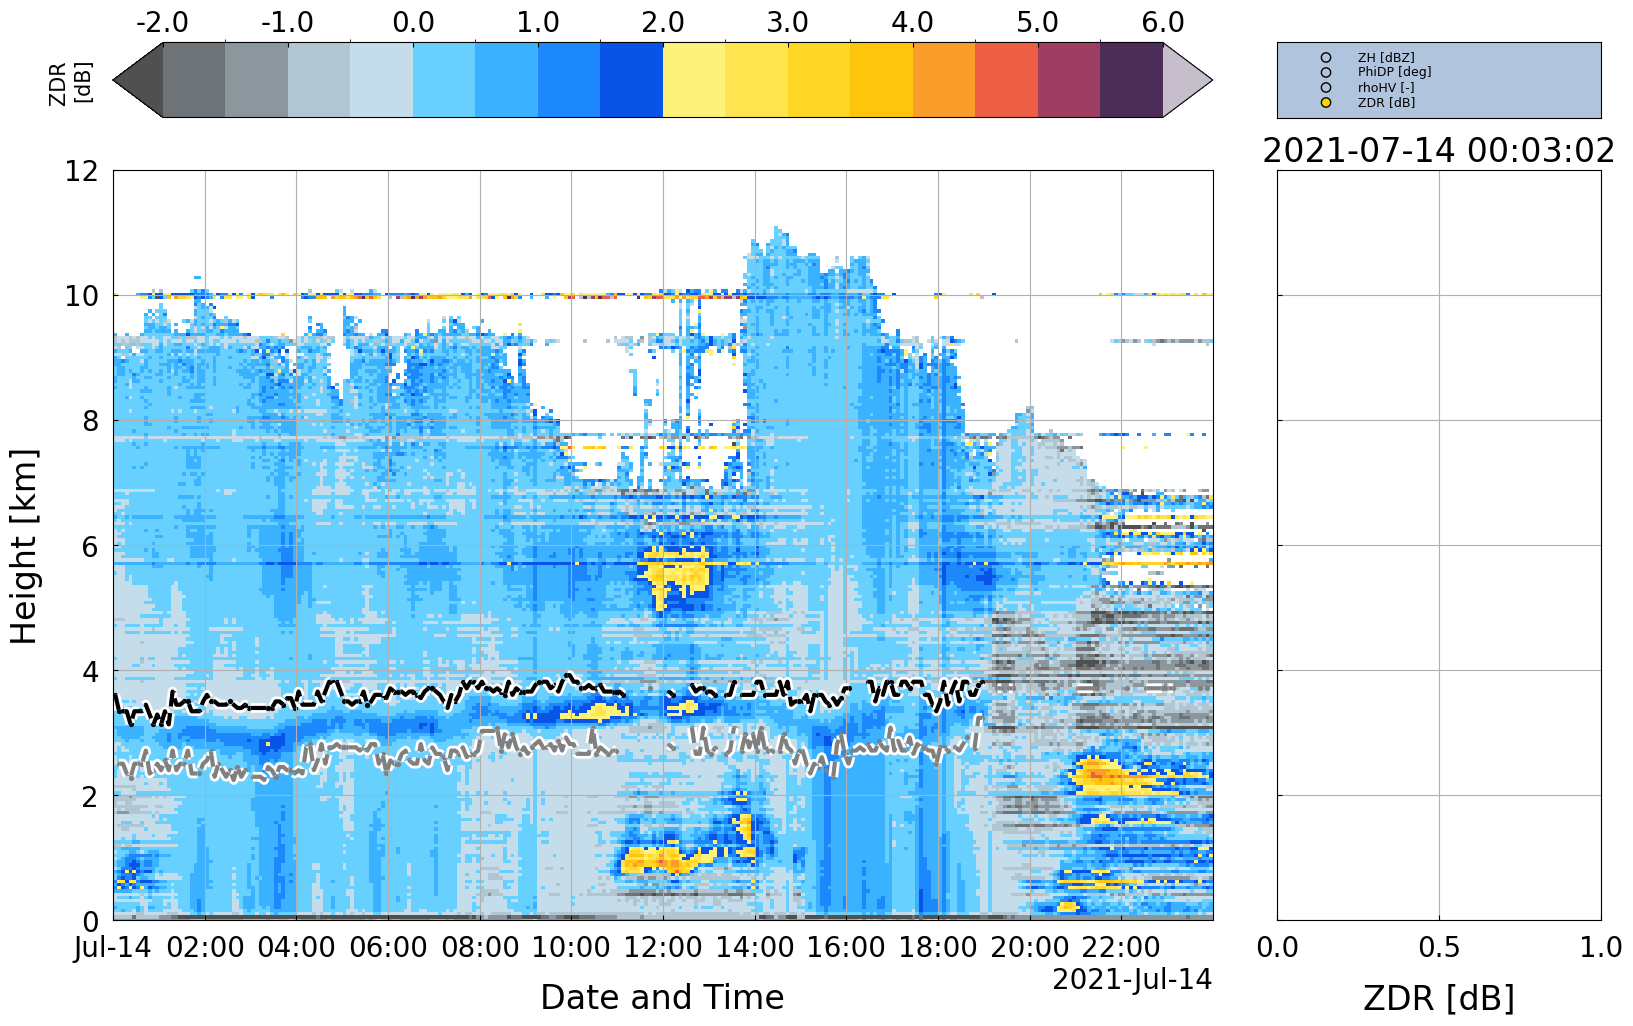

QVPs vertical resolution: 52.85 [m]
ML_THK (mean): 0.92 [km]


<Figure size 640x480 with 0 Axes>

In [7]:
for cnt, i in enumerate(rmlyr):
    # Remove unrealistic MLyrs
    if i.ml_bottom > i.ml_top:
        i.ml_bottom = np.nan
    if i.ml_top <= 0:
        i.ml_top = np.nan
    if i.ml_bottom <= 0.:
        i.ml_bottom = np.nan
    if i.ml_thickness <= 0.5:
        i.ml_bottom = i.ml_top - mlid['ml_t']
        i.thickness = i.ml_top - i.ml_bottom
    # Double-check the ML thickness
    i.thickness = i.ml_top - i.ml_bottom

tz = 'Europe/Berlin'
htixlim = None
htixlim = [
    DTWORK.replace(tzinfo=ZoneInfo(tz)),
    (DTWORK + dt.timedelta(seconds=86399)).replace(tzinfo=ZoneInfo(tz))]

radb = tp.datavis.rad_interactive.hti_base(rprofs, mlyrs=rmlyr, stats='std_dev',
                                           var2plot='ZDR [dB]', htiylim=[0, 12],
                                           htixlim=htixlim, tz=tz, fig_size=(19.2, 11.4))
radexpvis = tp.datavis.rad_interactive.HTI_Int()
radb.on_clicked(radexpvis.hzfunc)
plt.tight_layout()

print(f'QVPs vertical resolution: {qvps_res*1000:0.2f} [m]')
ml_thk = [i.ml_thickness for i in rmlyr]
mlid['ml_t'] = np.nanmean(ml_thk) + (0. if 'xpol' in RADAR_SITE else -0.)
print(f"ML_THK (mean): {mlid['ml_t']:.2f} [km]")


#### Single profile analysis

I check the algorithm's performance using an interactive plot that illustrates the steps taken by the ML detection algorithm for a single profile. This method computes all possible combinations of the normalised profiles, and adjusting the slider allows me to visualise the performance of each combination.

2021-07-14 17:38:02.300000+02:00


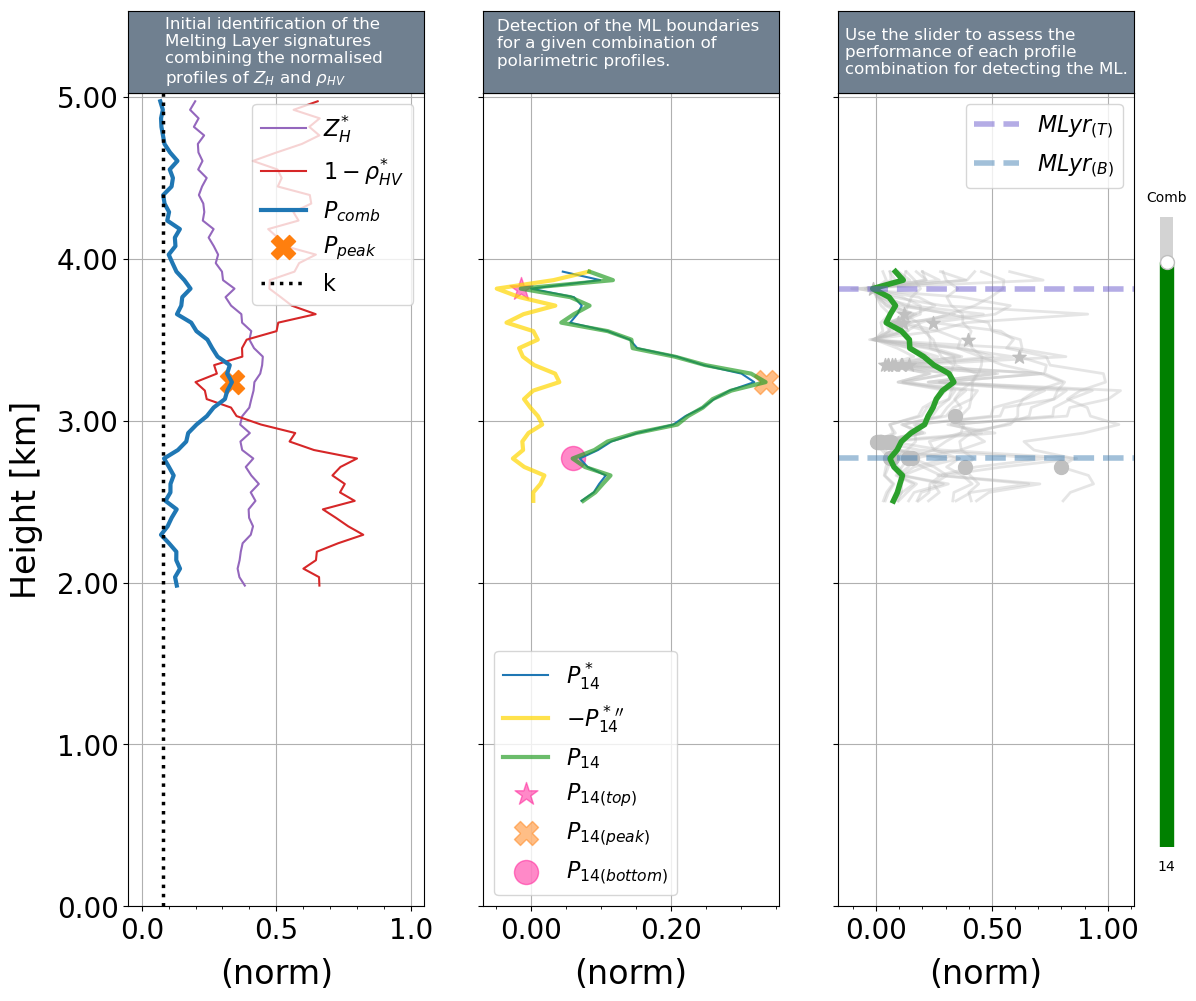

In [8]:
iprof = 211
print(rprofs[iprof].scandatetime)

rmlyr_i = tp.ml.mlyr.MeltingLayer(rprofs[iprof])
rmlyr_i.ml_detection(rprofs[iprof], min_h=mlid['minh'], max_h=mlid['maxh'],
                     param_k=mlid['kval'], param_w=mlid['wval'],
                     comb_id=mlid['comb'], phidp_peak=mlid['phidp'], plot_method=True)

#### Moving Average Filter application

I apply a moving average filter to the outputs of the MLID to produce more stable and consistent melting layer heights. The size of the moving average filter is 5 points (approximately 30 minutes). Some QC is also done in this step.

**To ensure bright band contamination is avoided, I add ~75 m to the height of both the top and bottom of the melting layer. This adjustment is especially beneficial for quantitative precipitation estimation (QPE) applications of the QVPs in subsequent steps.**

ML_TOP (mean): 3.65 [km]
ML_BTM (mean): 2.62 [km]
ML_THK (mean): 1.04 [km]


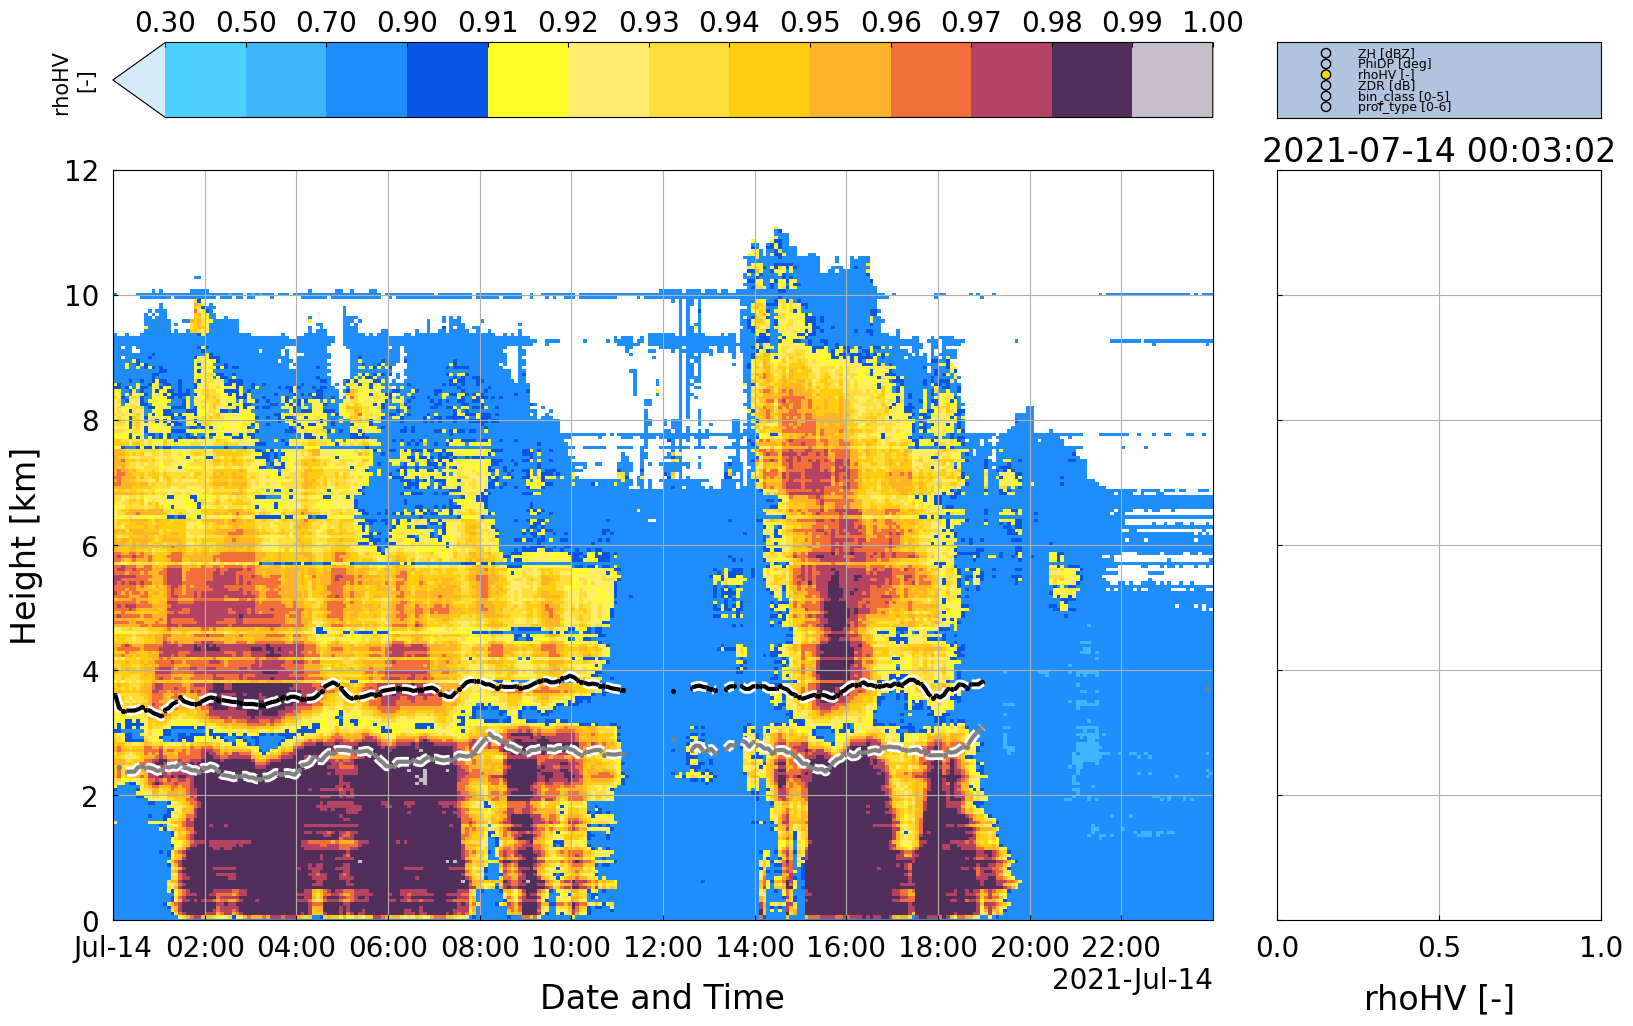

<Figure size 640x480 with 0 Axes>

In [19]:
mov_avrgf_len = 5
mlb_mavf = np.ma.convolve(tp.utils.radutilities.fillnan1d([i.ml_bottom
                                                           for i in rmlyr]),
                          np.ones(mov_avrgf_len)/mov_avrgf_len, mode='same')
mlt_mavf = np.ma.convolve(tp.utils.radutilities.fillnan1d([i.ml_top
                                                           for i in rmlyr]),
                          np.ones(mov_avrgf_len)/mov_avrgf_len, mode='same')
rmlyr2 = [tp.ml.mlyr.MeltingLayer(rd) for rd in rprofs]
for cnt, i in enumerate(rmlyr2):
    if cnt < 2:  # mov_avrgf_len:
        i.ml_top = rmlyr[cnt].ml_top
        i.ml_bottom = rmlyr[cnt].ml_bottom
        i.ml_thickness = i.ml_top - i.ml_bottom
    elif cnt >= len(rmlyr2) - 2:  # mov_avrgf_len:
        i.ml_top = rmlyr[cnt].ml_top
        i.ml_bottom = rmlyr[cnt].ml_bottom
        i.ml_thickness = i.ml_top - i.ml_bottom
    else:
        i.ml_top = mlt_mavf[cnt]
        i.ml_bottom = mlb_mavf[cnt]
        i.ml_thickness = i.ml_top - i.ml_bottom
for cnt, i in enumerate(rmlyr2):
    # Remove unrealistic MLyrs
    if i.ml_bottom > i.ml_top:
        i.ml_top = np.nan
        i.ml_bottom = np.nan
        i.thickness = np.nan
    if i.ml_top <= 0:
        i.ml_top = np.nan
    if i.ml_bottom <= 0.:
        i.ml_bottom = 0.0
    if not extend_mlyr:
        if np.isnan(rmlyr[cnt].ml_top) and np.isnan(rmlyr[cnt].ml_bottom):
            i.ml_top = np.nan
            i.ml_bottom = np.nan
            i.thickness = np.nan
     # Add 75 m to the top and bottom heights of the MLYR
    nbinshtb = float(np.round(75/(qvps_res*1000)))
    if ~np.isnan(rmlyr2[cnt].ml_top) and ~np.isnan(rmlyr2[cnt].ml_bottom):
        i.ml_top += qvps_res*nbinshtb
        i.ml_bottom -= qvps_res*nbinshtb
    # Remove unrealistic MLyrs
    if i.ml_thickness <= 0.5:
        i.ml_top = np.nan
        i.ml_bottom = np.nan
        i.thickness = np.nan
    # Double-check the ML thickness
    i.ml_thickness = i.ml_top - i.ml_bottom

ml_top = [i.ml_top for i in rmlyr2]
print(f'ML_TOP (mean): {np.nanmean(ml_top):.2f} [km]')
ml_btm = [i.ml_bottom for i in rmlyr2]
print(f'ML_BTM (mean): {np.nanmean(ml_btm):.2f} [km]')
ml_thk = [i.ml_thickness for i in rmlyr2]
print(f'ML_THK (mean): {np.nanmean(ml_thk):.2f} [km]')

tz = 'Europe/Berlin'
htixlim = None
htixlim = [
    DTWORK.replace(tzinfo=ZoneInfo(tz)),
    (DTWORK + dt.timedelta(seconds=86399)).replace(tzinfo=ZoneInfo(tz))]

radb = tp.datavis.rad_interactive.hti_base(rprofs, mlyrs=rmlyr2, stats='std_dev',
                                           var2plot='rhoHV [-]', htiylim=[0, 12],
                                           htixlim=htixlim, tz=tz, fig_size=(19.2, 11.4))
radexpvis = tp.datavis.rad_interactive.HTI_Int()
radb.on_clicked(radexpvis.hzfunc)
plt.tight_layout()


### Profile Classification

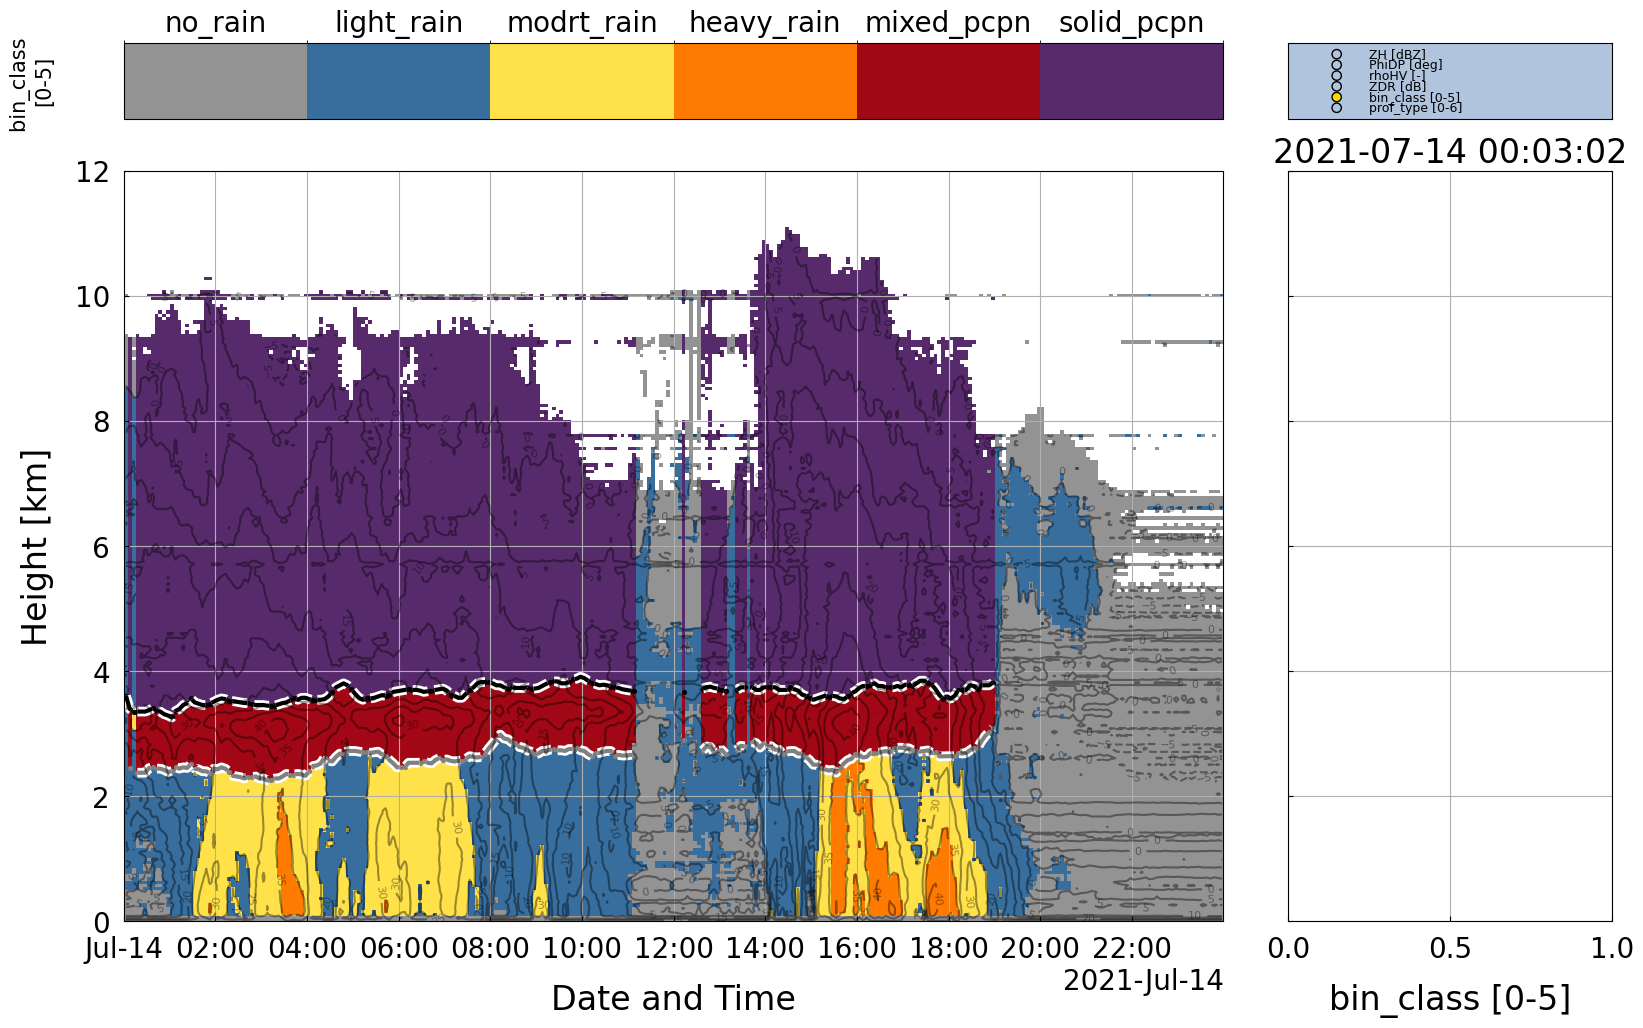

<Figure size 640x480 with 0 Axes>

In [11]:
min_hkm = (0.075 if 'xpol' in RADAR_SITE
           else (0.07 if DTWORK.year < 2021 else .1))
rhohv_thr_r = 0.80
rhohv_thr_p = (0.75 if 'xpol' in RADAR_SITE
               else (0.70 if DTWORK.year < 2021 else 0.75))

zh_thr_lr = 0
zh_thr_mr = 25
zh_thr_hr = 35

minbins_lr = float(np.ceil(200/(qvps_res*1000)))
minbins_mr = float(np.ceil(250/(qvps_res*1000)))
minbins_hr = float(np.ceil(100/(qvps_res*1000)))

for nprof, prf in enumerate(rprofs):
    rr = rmlyr2[nprof].ml_bottom
    mlt = rmlyr2[nprof].ml_top
    # Convective-Type (no MLYR)
    if np.isnan(rr):
        # Bins classification
        prf_class = np.where((prf.georef['profiles_height [km]'] > min_hkm)
                             & (prf.qvps['rhoHV [-]'] >= rhohv_thr_r)
                             & (prf.qvps['ZH [dBZ]'] >= zh_thr_lr), 1, 0)
        prf_class = np.where(
            (prf.georef['profiles_height [km]'] > min_hkm)
            & (prf.qvps['rhoHV [-]'] >= rhohv_thr_r)
            & (prf.qvps['ZH [dBZ]'] >= zh_thr_mr), 2, prf_class)
        prf_class = np.where(
            (prf.georef['profiles_height [km]'] > min_hkm)
            & (prf.qvps['rhoHV [-]'] >= rhohv_thr_r)
            & (prf.qvps['ZH [dBZ]'] >= zh_thr_hr), 3, prf_class)
        prf.qvps['bin_class [0-5]'] = np.zeros_like(
            prf.qvps['ZH [dBZ]']) + prf_class
        prf.qvps['bin_class [0-5]'][np.isnan(prf.qvps['ZH [dBZ]'])] = np.nan
        prf_class = prf.qvps['bin_class [0-5]']
        # Profile classification
        # TODO: improve by measuring the height of the rain in the QVPs
        if ((prf_class == 0).sum()
                / np.count_nonzero(~np.isnan(prf_class))) > 0.5:
            prf.pcp_type = 0
            prf.qvps['prof_type [0-6]'] = np.ones_like(
                prf.qvps['ZH [dBZ]']) * prf.pcp_type
        else:
            prf.pcp_type = 1 + 3  # 4
            prf.qvps['prof_type [0-6]'] = np.ones_like(
                prf.qvps['ZH [dBZ]']) * prf.pcp_type
        if (prf_class == 2).sum() >= minbins_mr:
            prf.pcp_type = 2 + 3  # 5
            prf.qvps['prof_type [0-6]'] = np.ones_like(
                prf.qvps['ZH [dBZ]']) * prf.pcp_type
        if (prf_class == 3).sum() >= minbins_hr:
            prf.pcp_type = 3 + 3  # 6
            prf.qvps['prof_type [0-6]'] = np.ones_like(
                prf.qvps['ZH [dBZ]']) * prf.pcp_type
        prf.qvps['prof_type [0-6]'][np.isnan(prf.qvps['ZH [dBZ]'])] = np.nan
    else:
        # Bins classification
        prf_class = np.where((prf.georef['profiles_height [km]'] >= min_hkm)
                             & (prf.georef['profiles_height [km]'] <= rr)
                             & (prf.qvps['rhoHV [-]'] >= rhohv_thr_r)
                             & (prf.qvps['ZH [dBZ]'] >= zh_thr_lr),
                             1, 0)
        prf_class = np.where((prf.georef['profiles_height [km]'] >= min_hkm)
                             & (prf.georef['profiles_height [km]'] <= rr)
                             & (prf.qvps['rhoHV [-]'] >= rhohv_thr_r)
                             & (prf.qvps['ZH [dBZ]'] >= zh_thr_mr),
                             2, prf_class)
        prf_class = np.where((prf.georef['profiles_height [km]'] >= min_hkm)
                             & (prf.georef['profiles_height [km]'] <= rr)
                             & (prf.qvps['rhoHV [-]'] >= rhohv_thr_r)
                             & (prf.qvps['ZH [dBZ]'] >= zh_thr_hr),
                             3, prf_class)
        prf_class = np.where((prf.georef['profiles_height [km]'] > rr)
                             & (prf.qvps['ZH [dBZ]'] >= zh_thr_lr)
                             & (prf.georef['profiles_height [km]'] <= mlt),
                             4, prf_class)
        prf_class = np.where((prf.georef['profiles_height [km]'] > mlt)
                             & (prf.qvps['rhoHV [-]'] >= rhohv_thr_p),
                             5, prf_class)
        prf.qvps['bin_class [0-5]'] = np.zeros_like(
            prf.qvps['ZH [dBZ]']) + prf_class
        prf.qvps['bin_class [0-5]'][np.isnan(prf.qvps['ZH [dBZ]'])] = np.nan
        prf_class = prf.qvps['bin_class [0-5]']
        # Profile classification
        if ((prf_class == 0).sum()
                / np.count_nonzero(~np.isnan(prf_class))) > 0.5:
            prf.pcp_type = 0
            prf.qvps['prof_type [0-6]'] = np.ones_like(
                prf.qvps['ZH [dBZ]']) * prf.pcp_type
        else:
            prf.pcp_type = 1
            prf.qvps['prof_type [0-6]'] = np.ones_like(
                prf.qvps['ZH [dBZ]']) * prf.pcp_type
        if (prf_class == 2).sum() >= minbins_mr:
            prf.pcp_type = 2
            prf.qvps['prof_type [0-6]'] = np.ones_like(
                prf.qvps['ZH [dBZ]']) * prf.pcp_type
        if (prf_class == 3).sum() >= minbins_hr:
            prf.pcp_type = 3
            prf.qvps['prof_type [0-6]'] = np.ones_like(
                prf.qvps['ZH [dBZ]']) * prf.pcp_type
        prf.qvps['prof_type [0-6]'][np.isnan(prf.qvps['ZH [dBZ]'])] = np.nan

    prf.qvps.pop('prof_type [0-1]', None)
    prf.qvps.pop('class [0-1]', None)

v2p = 'bin_class [0-5]'

pbins_class = {'no_rain': 0.5, 'light_rain': 1.5, 'modrt_rain': 2.5,
               'heavy_rain': 3.5, 'mixed_pcpn': 4.5, 'solid_pcpn': 5.5}
prof_type = {'NR': 0.5, 'LR [STR]': 1.5, 'MR [STR]': 2.5, 'HR [STR]': 3.5,
             'LR [CNV]': 4.5, 'MR [CNV]': 5.5, 'HR [CNV]': 6.5}


if v2p == 'bin_class [0-5]':
    ptype = 'pseudo'
    ucmap = 'tpylsc_rad_model'
    cbticks = pbins_class
elif v2p == 'prof_type [0-6]':
    ptype = 'pseudo'
    ucmap = 'coolwarm'
    ucmap = 'tpylsc_div_dbu_rd_r'
    ucmap = 'terrain'
    cbticks = prof_type

radb = tp.datavis.rad_interactive.hti_base(rprofs, mlyrs=rmlyr2,
                                           var2plot=v2p, contourl='ZH [dBZ]',
                                           ptype=ptype, ucmap=ucmap,
                                           vars_bounds={'bin_class [0-5]':
                                                        (0, 6, 7),
                                                        'prof_type [0-6]':
                                                        (0, 7, 8)},
                                           cbticks=cbticks, tz=tz,
                                           htiylim=[0, 12], htixlim=htixlim,
                                           fig_size=(19.2, 11.4))
radexpvis = tp.datavis.rad_interactive.HTI_Int()
radb.on_clicked(radexpvis.hzfunc)
plt.tight_layout()

### Differential reflectivity $(Z_{DR})$ offset detection

The `offsetdetection_qvps` function adapts the method proposed by **Sanchez-Rivas, D. and Rico-Ramirez, M. A. (2022)** to detect the $Z_{DR}$ offset using QVPs.

The mlyr is required to separate between liquid and solid precipitation. Whereas the min_h and other arguments help adjust the algorithm’s performance.

According to this method, the intrinsic value of $Z_{DR}$ in light rain at ground level is required. The default value is 0.182 dB. See the paper for a more detailed description.

In [12]:
min_hkm_zdr = (0.0185 if 'xpol' in RADAR_SITE
               else (0.17 if DTWORK.year < 2021 else .1))
min_hkm_phidp = (0.0175 if 'xpol' in RADAR_SITE
                 else (0.2 if DTWORK.year < 2021 else 0.2))
zh_thr_lr = (20 if 'xpol' in RADAR_SITE
             else (25 if DTWORK.year < 2021 else 20))
# rhv_min = 0.985 if 'xpol' in RADAR_SITE else 0.95  # 0.95 old res 0.975
rhv_min = (0.985 if 'xpol' in RADAR_SITE
           else (0.97 if DTWORK.year < 2021 else 0.985))
# min_binsO = float(np.ceil(250/(qvps_res*1000)))
min_binsO = float(np.ceil(200/(qvps_res*1000)))
maf_offset = True

# =============================================================================
# ZDR offset detection
# =============================================================================
roffzdr = [tp.calib.calib_zdr.ZDR_Calibration(rd) for rd in rprofs]
[robj.offsetdetection_qvps(pol_profs=rprofs[i], mlyr=rmlyr2[i],
                           min_h=min_hkm_zdr, zhmax=zh_thr_lr, rhvmin=rhv_min,
                           minbins=min_binsO)
 for i, robj in enumerate(tqdm(roffzdr, desc='roffzdry_towerpy'))]

# =============================================================================
# ZDR OFFSET QC
# =============================================================================
zdro = np.array([i.zdr_offset for i in roffzdr], dtype=float)
zdro[zdro == 0] = np.nan
if np.isnan(zdro[0]) and not np.isnan(zdro).all():
    zdro[0] = zdro[np.isfinite(zdro)][0]
if np.isnan(zdro).all():
    zdro[0] = 0.0

zdro = tp.utils.radutilities.fillnan1d(zdro)
if maf_offset:
    zdro_maf = np.ma.convolve(
        tp.utils.radutilities.fillnan1d([i for i in zdro]),
        np.ones(mov_avrgf_len)/mov_avrgf_len, mode='same')
    maw_adj = mov_avrgf_len - 2
    zdro[maw_adj:-maw_adj] = zdro_maf[maw_adj:-maw_adj]

for cnt, robj in enumerate(roffzdr):
    robj.zdr_offset = zdro[cnt]

# =============================================================================
# ZDR bias adjustment
# =============================================================================
zdr_oc = True
zdro = np.array([i.zdr_offset for i in roffzdr])

if zdr_oc:
    for cnt, rp in enumerate(rprofs):
        rp.qvps['ZDR [dB]'] -= zdro[cnt]


roffzdry_towerpy: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 7088.92it/s]


###  Differential phase $(\Phi_{DP})$ offset detection

In [14]:
roffpdp = [tp.calib.calib_phidp.PhiDP_Calibration(rd) for rd in rprofs]
[robj.offsetdetection_qvps(
    pol_profs=rprofs[i], mlyr=rmlyr2[i], min_h=min_hkm_phidp, zhmax=zh_thr_lr,
    rhvmin=rhv_min, minbins=min_binsO)
 for i, robj in enumerate(tqdm(roffpdp, desc='rcalphidpx_towerpy'))]

# =============================================================================
# PHIDP OFFSET QC
# =============================================================================
phidpo = np.array([i.phidp_offset for i in roffpdp], dtype=float)
phidpo[phidpo == 0] = np.nan
if np.isnan(phidpo[0]) and not np.isnan(phidpo).all():
    phidpo[0] = phidpo[np.isfinite(phidpo)][0]
if np.isnan(phidpo).all():
    phidpo[0] = 0 
phidpo = tp.utils.radutilities.fillnan1d(phidpo)
if maf_offset:
    phidpo_maf = np.ma.convolve(
        tp.utils.radutilities.fillnan1d([i for i in phidpo]),
        np.ones(mov_avrgf_len)/mov_avrgf_len, mode='same')
    phidpo[maw_adj:-maw_adj] = phidpo_maf[maw_adj:-maw_adj]

for cnt, robj in enumerate(roffpdp):
    robj.phidp_offset = phidpo[cnt]

# =============================================================================
# PhiDP bias adjustment
# =============================================================================
phidp_oc = False
phidpo = np.array([i.phidp_offset for i in roffpdp])
if phidp_oc:
    for cnt, rp in enumerate(rprofs):
        rp.qvps['PhiDP [deg]'] -= phidpo[cnt]



rcalphidpx_towerpy: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 8977.97it/s]


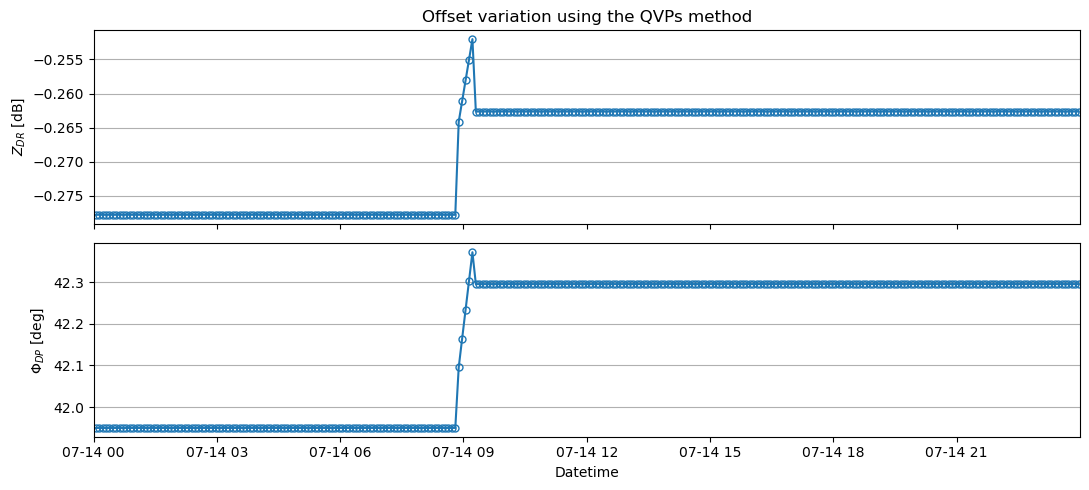

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(11, 5), sharex=(True))
axs = ax[0]
axs.set_title('Offset variation using the QVPs method')
axs.plot([i.scandatetime for i in rprofs],
         np.array([i.zdr_offset for i in roffzdr]),
         marker='o', ms=5, mfc='None', label='QVPs data')
axs.grid(axis='y')
axs.tick_params(axis='both', labelsize=10)
axs.set_ylabel(r'$Z_{DR}$ [dB]', fontsize=10)
axs = ax[1]
axs.plot([i.scandatetime for i in rprofs],
         np.array([i.phidp_offset for i in roffpdp]),
         marker='o', ms=5, mfc='None', label='QVPs data')
axs.grid(axis='y')
axs.tick_params(axis='both', labelsize=10)
axs.set_ylabel(r'$\Phi_{DP}$ [deg]', fontsize=10)
axs.set_xlabel('Datetime', fontsize=10)
plt.xlim(htixlim)
plt.tight_layout()

In [17]:
# =============================================================================
# Adjust relative height
# =============================================================================
adjh = False
if adjh:
    RSITESH = {'Boxpol': 99.50, 'Juxpol': 310.00, 'Essen': 185.11,
               'Flechtdorf': 627.88, 'Neuheilenbach': 585.85,
               'Offenthal': 245.80}
    # Add rheight to mlyrs to work with hAMSL
    for ml in rmlyr2:
        ml.ml_top = ml.ml_top + RSITESH[RADAR_SITE]/1000
        ml.ml_bottom = ml.ml_bottom + RSITESH[RADAR_SITE]/1000
        ml.thickness = ml.ml_top - ml.ml_bottom
    # Add rheight to profs to work with hAMSL
    for pr in rprofs:
        pr.georef['profiles_height [km]'] += RSITESH[RADAR_SITE]/1000

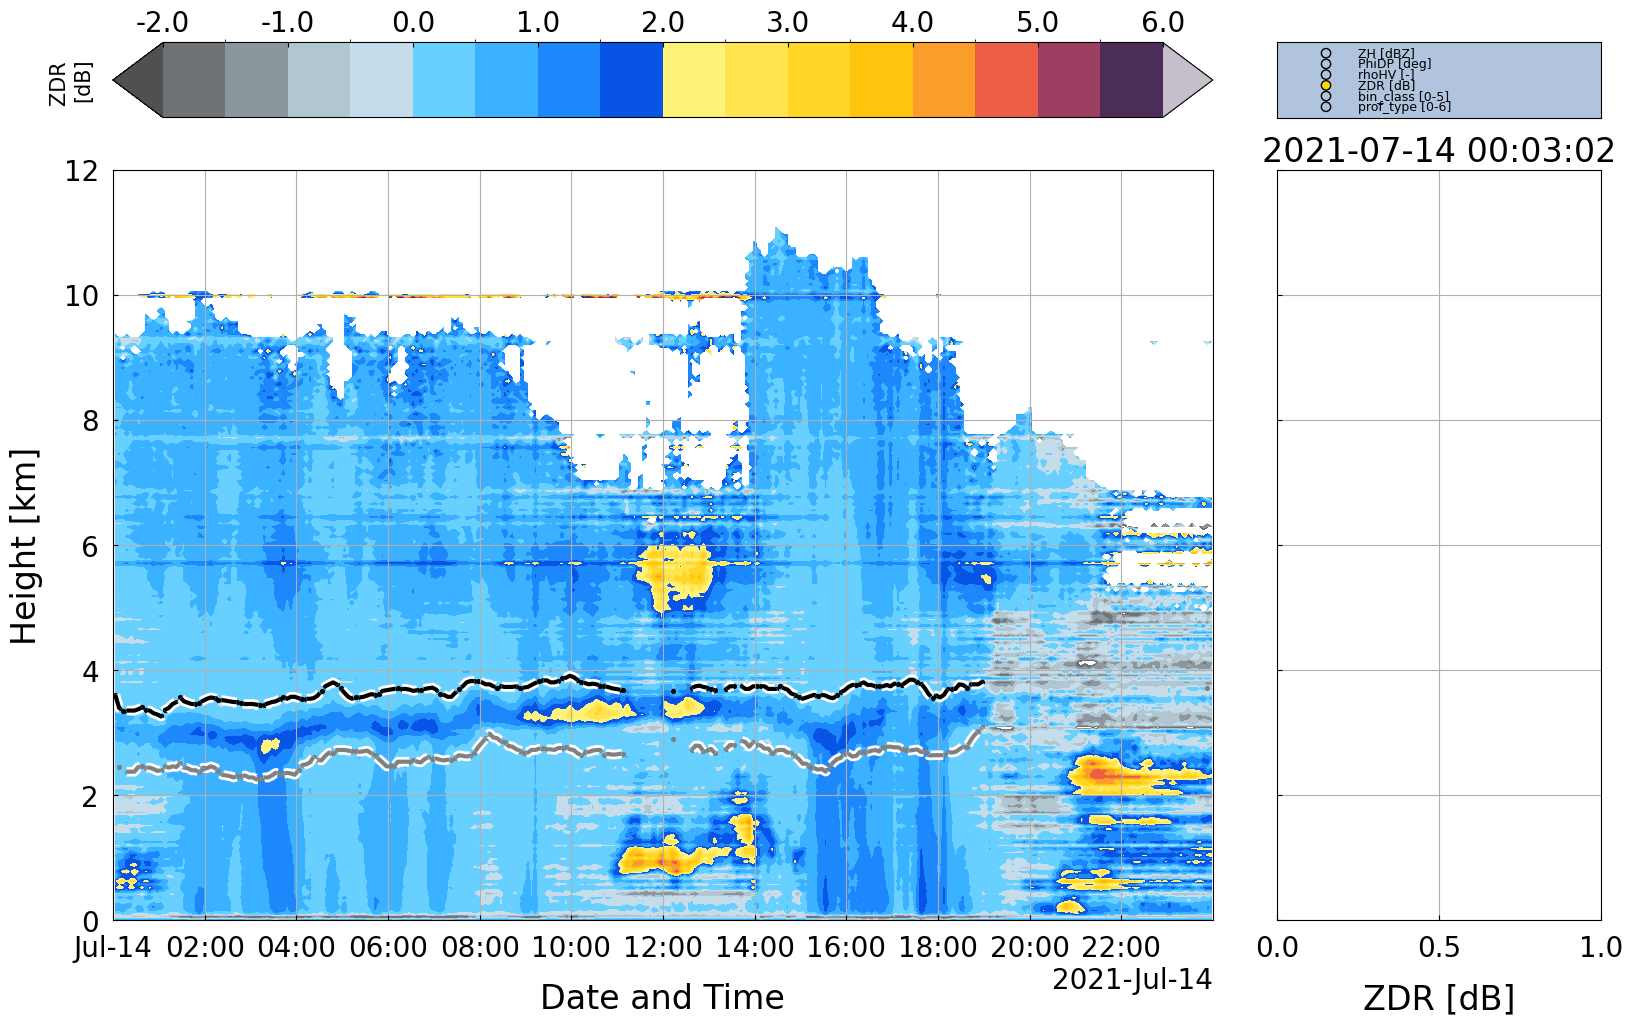

<Figure size 640x480 with 0 Axes>

In [18]:
v2p = 'ZH [dBZ]'
v2p = 'ZDR [dB]'
# v2p = 'rhoHV [-]'
# v2p = 'bin_class [0-5]'
# v2p = 'prof_type [0-6]'
# v2p='PhiDP [deg]'

pbins_class = {'no_rain': 0.5, 'light_rain': 1.5, 'modrt_rain': 2.5,
               'heavy_rain': 3.5, 'mixed_pcpn': 4.5, 'solid_pcpn': 5.5}
prof_type = {'NR': 0.5, 'LR [STR]': 1.5, 'MR [STR]': 2.5, 'HR [STR]': 3.5,
             'LR [CNV]': 4.5, 'MR [CNV]': 5.5, 'HR [CNV]': 6.5}


if v2p == 'bin_class [0-5]':
    ptype = 'pseudo'
    ucmap = 'tpylsc_rad_model'
    cbticks = pbins_class
elif v2p == 'prof_type [0-6]':
    ptype = 'pseudo'
    ucmap = 'coolwarm'
    ucmap = 'tpylsc_div_dbu_rd_r'
    ucmap = 'terrain'
    # ucmap = 'cividis'
    cbticks = prof_type
else:
    ptype = 'fcontour'
    # ptype = 'pseudo'
    ucmap = None
    cbticks = None

radb = tp.datavis.rad_interactive.hti_base(rprofs, mlyrs=rmlyr2,
                                           # stats='std_dev',
                                           var2plot=v2p,
                                           vars_bounds={'bin_class [0-5]':
                                                        (0, 6, 7),
                                                        'prof_type [0-6]':
                                                        (0, 7, 8)},
                                           ptype=ptype, ucmap=ucmap,
                                           htiylim=[0, 12], htixlim=htixlim,
                                           cbticks=cbticks,
                                           # contourl='rhoHV [-]',
                                           # contourl='ZH [dBZ]',
                                           tz=tz, fig_size=(19.2, 11.4))
radexpvis = tp.datavis.rad_interactive.HTI_Int()
radb.on_clicked(radexpvis.hzfunc)
plt.tight_layout()



## References

- Sanchez-Rivas, D., & Rico-Ramirez, M. A. (2021). Detection of the melting level with polarimetric weather radar. Atmospheric Measurement Techniques, 14(4), 2873–2890. https://doi.org/10.5194/amt-14-2873-2021
- Sanchez-Rivas, D., & Rico-Ramirez, M. A. (2022). Calibration of radar differential reflectivity using quasi-vertical profiles. Atmospheric Measurement Techniques, 15(2), 503–520. https://doi.org/10.5194/amt-15-503-2022
- Sanchez-Rivas, D., & Rico-Ramirez, M. A. (2023). Towerpy: An open-source toolbox for processing polarimetric weather radar data. Environmental Modelling & Software, 167, 105746. https://doi.org/10.1016/j.envsoft.2023.105746